In [146]:
# https://keras.io/callbacks/
import pandas as pd 
import numpy as np
import seaborn as sns
import random
import time
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input,Dropout,Dense,Activation,Convolution2D,MaxPooling2D,Flatten
from keras.optimizers import Adam,Adagrad,RMSprop,rmsprop
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
%matplotlib inline

In [147]:
## loading data
train_dir = '/Users/xingobar/Downloads/animal_train/'
test_dir = '/Users/xingobar/Downloads/animal_test/'

train_images = [ train_dir + str(i) for i in os.listdir(train_dir)]
dogs = [train_dir + str(i) for i in os.listdir(train_dir) if 'dog' in i]
cats = [train_dir + str(i) for i in os.listdir(train_dir) if 'cat' in i]
test_images = [test_dir + str(i) for i in os.listdir(test_dir)]

In [148]:
train_images = dogs[:len(dogs)] + cats[:len(cats)]
#test_images = test_images[:25]
random.shuffle(train_images)

In [149]:
rows  = 64
cols = 64
color_channel = 3
def read_image(images):
    img = cv2.imread(images,cv2.IMREAD_COLOR)
    return cv2.resize(img,(rows,cols),interpolation = cv2.INTER_CUBIC)

In [150]:
def prepare_data(images):
    image_length = len(images) # counts 
    data = np.ndarray((image_length,color_channel,rows,cols),dtype=np.uint8)
    for i,image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i % 250 ==0 : print '%d of %d '%(i,image_length)
    return data

In [151]:
train = prepare_data(train_images)
test = prepare_data(test_images)

0 of 25000 
250 of 25000 
500 of 25000 
750 of 25000 
1000 of 25000 
1250 of 25000 
1500 of 25000 
1750 of 25000 
2000 of 25000 
2250 of 25000 
2500 of 25000 
2750 of 25000 
3000 of 25000 
3250 of 25000 
3500 of 25000 
3750 of 25000 
4000 of 25000 
4250 of 25000 
4500 of 25000 
4750 of 25000 
5000 of 25000 
5250 of 25000 
5500 of 25000 
5750 of 25000 
6000 of 25000 
6250 of 25000 
6500 of 25000 
6750 of 25000 
7000 of 25000 
7250 of 25000 
7500 of 25000 
7750 of 25000 
8000 of 25000 
8250 of 25000 
8500 of 25000 
8750 of 25000 
9000 of 25000 
9250 of 25000 
9500 of 25000 
9750 of 25000 
10000 of 25000 
10250 of 25000 
10500 of 25000 
10750 of 25000 
11000 of 25000 
11250 of 25000 
11500 of 25000 
11750 of 25000 
12000 of 25000 
12250 of 25000 
12500 of 25000 
12750 of 25000 
13000 of 25000 
13250 of 25000 
13500 of 25000 
13750 of 25000 
14000 of 25000 
14250 of 25000 
14500 of 25000 
14750 of 25000 
15000 of 25000 
15250 of 25000 
15500 of 25000 
15750 of 25000 
16000 of 25000 
16250 

In [152]:
print 'train shape : ' ,train.shape
print 'test shape : ' , test.shape

train shape :  (25000, 3, 64, 64)
test shape :  (12500, 3, 64, 64)


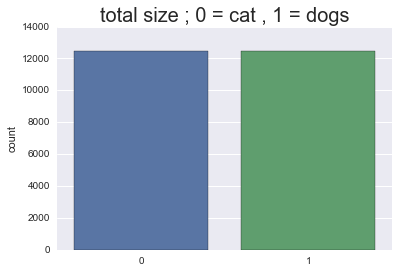

In [155]:
labels = []
for i in train_images:
    if 'dog' in i :
        labels.append(1)
    elif 'cat' in i:
        labels.append(0)
sns.countplot(labels)
plt.title('total size ; 0 = cat , 1 = dogs',fontsize=20)

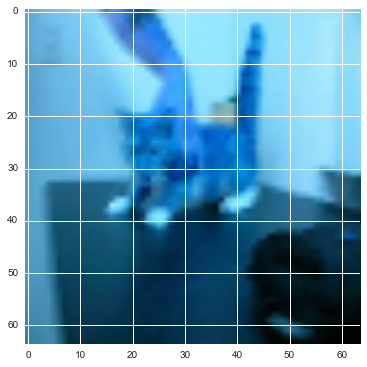

In [128]:
plt.figure(figsize=(18,6))
plt.imshow(read_image(cats[0]))
plt.show()

In [153]:
def CNN():
    model  =Sequential()
    model.add(Convolution2D(32,3,3,input_shape=(color_channel,rows,cols),border_mode='same',activation='relu'))
    model.add(Convolution2D(32,3,3,border_mode='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(64,3,3,border_mode='same',activation='relu'))
    model.add(Convolution2D(64,3,3,border_mode='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(128,3,3,border_mode='same',activation='relu'))
    model.add(Convolution2D(128,3,3,border_mode='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(256,3,3,border_mode='same',activation='relu'))
    model.add(Convolution2D(256,3,3,border_mode='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    
    #model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    
    #model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    
    return model
cnn = CNN()
    

In [156]:
nb_epoch = 10
batch_size = 16


print 'Starting ....'
start_time = time.time()
class History(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_model():
    
    history = History()
    cnn.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = cnn.predict(test, verbose=0)
    return predictions, history

predictions, history = run_model()
print 'Finishing ....'
print 'Time is %.2f ' %((time.time() - start_time) / 60)

Starting ....
Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 820s - loss: 0.6669 - acc: 0.6003 - val_loss: 0.5945 - val_acc: 0.6741
Epoch 2/10
18750/18750 [==============================] - 770s - loss: 0.5314 - acc: 0.7382 - val_loss: 0.4842 - val_acc: 0.7670
Epoch 3/10
18750/18750 [==============================] - 768s - loss: 0.4525 - acc: 0.7945 - val_loss: 0.4173 - val_acc: 0.8099
Epoch 4/10
18750/18750 [==============================] - 733s - loss: 0.4062 - acc: 0.8258 - val_loss: 0.3835 - val_acc: 0.8250
Epoch 5/10
18750/18750 [==============================] - 735s - loss: 0.3725 - acc: 0.8441 - val_loss: 0.3909 - val_acc: 0.8270
Epoch 6/10
18750/18750 [==============================] - 739s - loss: 0.3369 - acc: 0.8587 - val_loss: 0.3573 - val_acc: 0.8398
Epoch 7/10
18750/18750 [==============================] - 743s - loss: 0.3056 - acc: 0.8763 - val_loss: 0.4552 - val_acc: 0.8470
Epoch 8/10
18750/18750 [==========

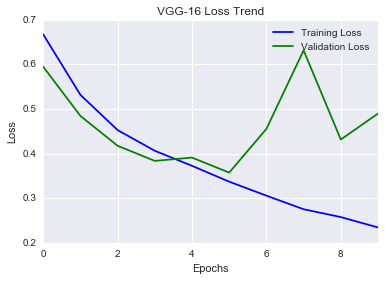

In [157]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [196]:
columns = ['id','label']
df_results = pd.DataFrame(columns=columns)
for i in range(0,len(test)):
    if predictions[i,0] >=0.5 :
        pred = predictions[i,0]
        #print 'it is a dog %.2f probability ' %(predictions[i,0])
        
    else:
        pred =  predictions[i,0]
        #print 'it is a cat  %.2f probability ' %(1 - predictions[i,0])
    entry = pd.DataFrame([[i+1,pred]] , columns=columns)
    df_results = df_results.append(entry)

In [197]:
df_results.head()

,id,label
0,1.0,0.992990
0,2.0,0.000046
0,3.0,0.023557
0,4.0,1.000000
0,5.0,0.984717


In [169]:
df_results = df_results.reset_index()
df_results.drop(['index'],axis=1,inplace=True)
df_results.head()

,level_0,id,label
0,0,1.0,0.992990
1,1,2.0,0.999954
2,2,3.0,0.976443
3,3,4.0,1.000000
4,4,5.0,0.984717


In [170]:
df_results.drop(['level_0'],axis=1,inplace=True)
df_results.head()

,id,label
0,1.0,0.992990
1,2.0,0.999954
2,3.0,0.976443
3,4.0,1.000000
4,5.0,0.984717


In [173]:
df_results['id'] = df_results['id'].astype(np.int8)
df_results.head()

,id,label
0,1,0.992990
1,2,0.999954
2,3,0.976443
3,4,1.000000
4,5,0.984717


In [175]:
df_results.to_csv('dogs_cats_classification.csv',index=False)

In [182]:
test_images.split('/Users/xingobar/Downloads/animal_test/')

AttributeError: 'list' object has no attribute 'split'

In [198]:
ids = []
for i in test_images:
    i = i.split('/Users/xingobar/Downloads/animal_test/')[1]
    #print i
    i = i.split('.jpg')[0]
    ids.append(i)

In [199]:
df_results.insert(0,'test',ids)

In [200]:
df_results.drop(['id'],axis=1,inplace=True)

In [201]:
df_results.rename(columns={'test':'id'},inplace=True)
df_results.head()

,id,label
0,1,0.992990
0,10,0.000046
0,100,0.023557
0,1000,1.000000
0,10000,0.984717


In [202]:
df_results.to_csv('dogs_cats_classification.csv',index=False)